# 📈 Advanced Pairs Trading Strategy
This notebook demonstrates a complete pairs trading workflow including cointegration testing, z-score calculation, signal generation, and performance visualization.

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

## Step 1: Download Historical Data

In [23]:
import yfinance as yf

t1, t2 = 'AAPL', 'MSFT'
start_date = '2018-01-01'
end_date = '2024-12-31'

df = yf.download([t1, t2], start=start_date, end=end_date)['Close'].dropna()
print(df.head())


[*********************100%***********************]  2 of 2 completed

Ticker           AAPL       MSFT
Date                            
2018-01-02  40.380997  79.198311
2018-01-03  40.373951  79.566910
2018-01-04  40.561504  80.267212
2018-01-05  41.023304  81.262390
2018-01-08  40.870941  81.345291


## Step 2: Visualize Price Series

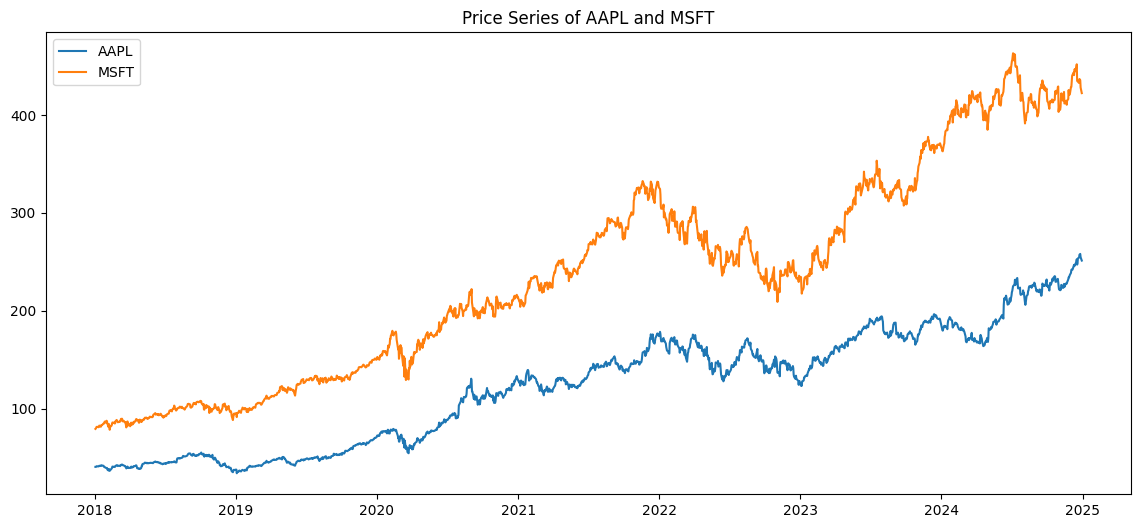

In [24]:
plt.figure(figsize=(14,6))
plt.plot(df[t1], label=t1)
plt.plot(df[t2], label=t2)
plt.title(f'Price Series of {t1} and {t2}')
plt.legend()
plt.show()

## Step 3: Cointegration Test

In [25]:
score, pvalue, _ = coint(df[t1], df[t2])
print(f'Cointegration test p-value: {pvalue:.4f}')

Cointegration test p-value: 0.5294


## Step 4: Compute Hedge Ratio and Spread

In [26]:
X = sm.add_constant(df[t2])
model = sm.OLS(df[t1], X).fit()
hedge_ratio = model.params[1]
spread = df[t1] - hedge_ratio * df[t2]
print(f'Hedge Ratio: {hedge_ratio:.3f}')

Hedge Ratio: 0.537


## Step 5: Plot Spread and Z-Score

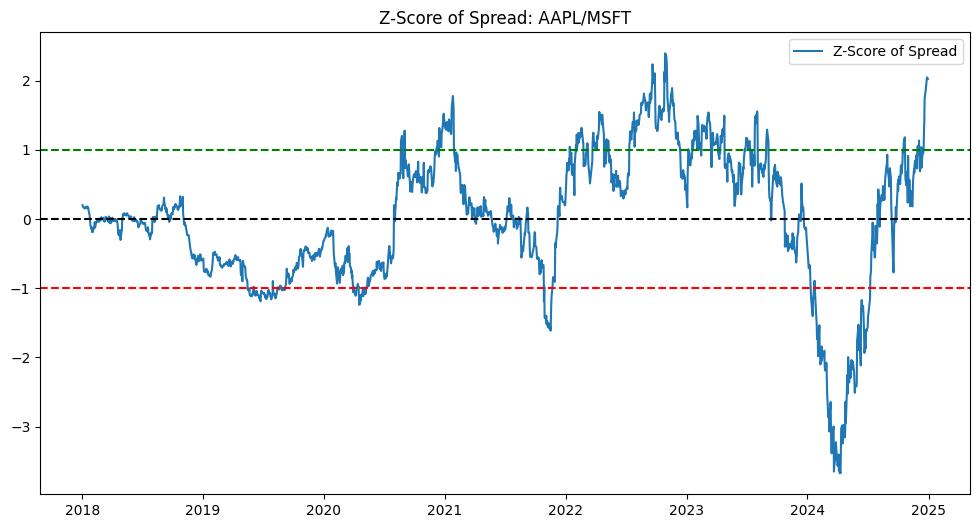

In [27]:
spread_mean = spread.mean()
spread_std = spread.std()
zscore = (spread - spread_mean) / spread_std

plt.figure(figsize=(12,6))
plt.plot(zscore, label='Z-Score of Spread')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(-1, color='red', linestyle='--')
plt.title(f'Z-Score of Spread: {t1}/{t2}')
plt.legend()
plt.show()

## Step 6: Spread and Rolling Statistics

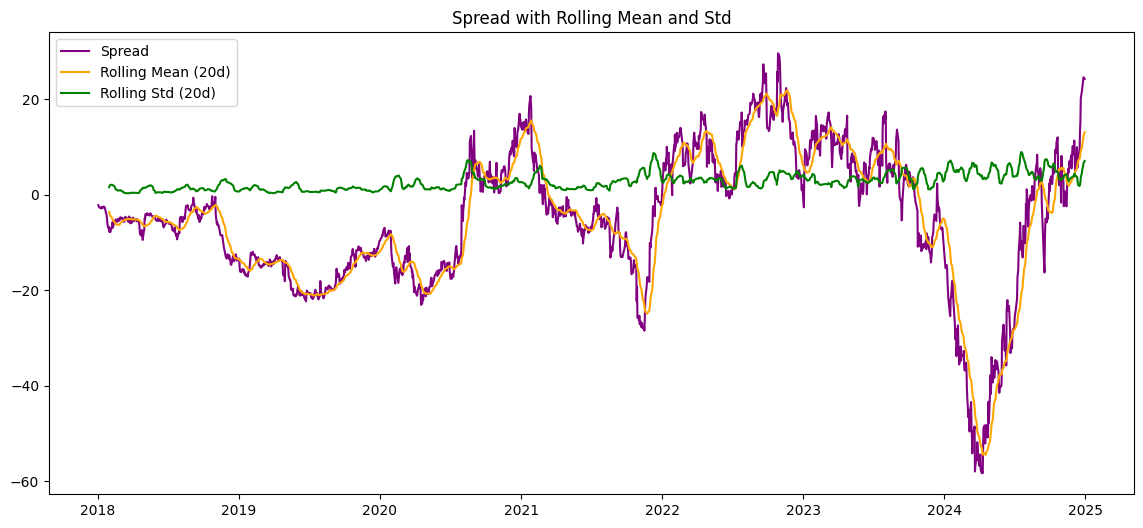

In [28]:
rolling_mean = spread.rolling(20).mean()
rolling_std = spread.rolling(20).std()

plt.figure(figsize=(14,6))
plt.plot(spread, label='Spread', color='purple')
plt.plot(rolling_mean, label='Rolling Mean (20d)', color='orange')
plt.plot(rolling_std, label='Rolling Std (20d)', color='green')
plt.legend()
plt.title('Spread with Rolling Mean and Std')
plt.show()

## Step 7: Histogram of Z-Score

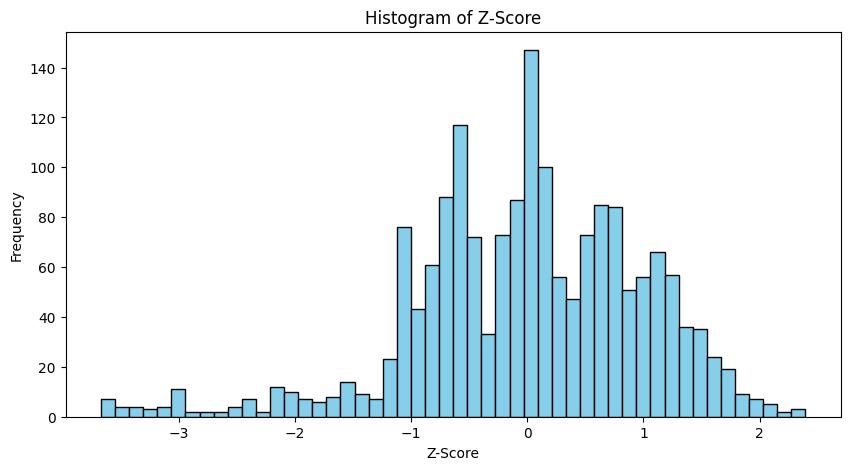

In [29]:
plt.figure(figsize=(10,5))
plt.hist(zscore, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Z-Score')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

## Step 8: Trading Strategy and Cumulative Returns

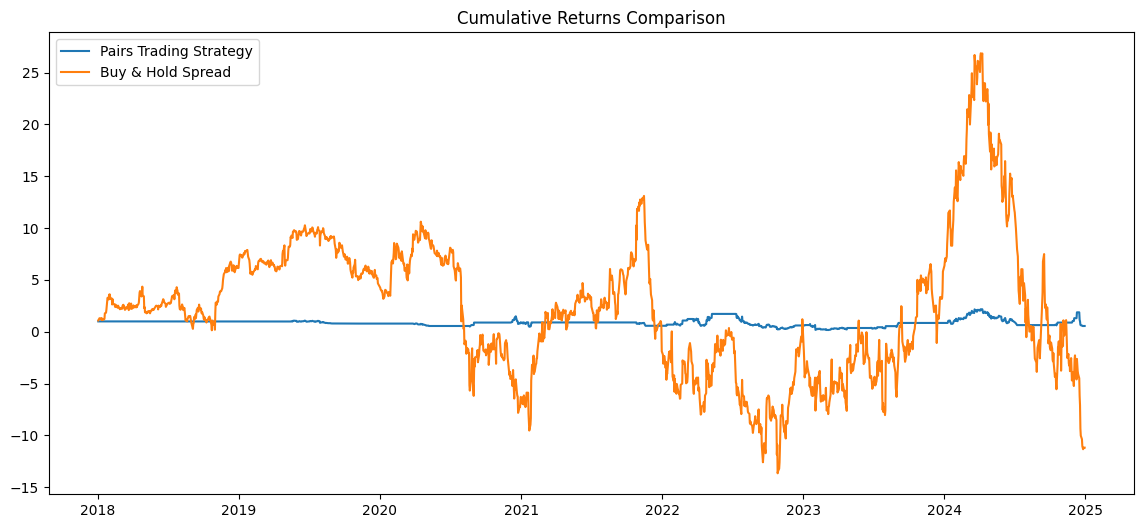

In [30]:
long_signal = zscore < -1
short_signal = zscore > 1
spread_returns = spread.pct_change().shift(-1)
strategy_returns = spread_returns.copy()
strategy_returns[long_signal] = spread_returns[long_signal]
strategy_returns[short_signal] = -spread_returns[short_signal]
strategy_returns[~(long_signal | short_signal)] = 0

cumulative_strategy = (1 + strategy_returns.fillna(0)).cumprod()
cumulative_hold = (1 + spread_returns.fillna(0)).cumprod()

plt.figure(figsize=(14,6))
plt.plot(cumulative_strategy, label='Pairs Trading Strategy')
plt.plot(cumulative_hold, label='Buy & Hold Spread')
plt.legend()
plt.title('Cumulative Returns Comparison')
plt.show()